In [2]:
import numpy as np
import matplotlib.pyplot as plt

from ipynb.fs.full.SeedMaskExtractor import extract_seed_pixels, get_all_seeds_pixels_in_folder

In [3]:
def plot_spectra(spectra, title='Spectra', start_wavelength=395, end_wavelength=1005, num_bands=840, start_band=100, end_band=740, is_log=False):
    wavelengths = np.linspace(start_wavelength, end_wavelength, num_bands)[start_band:end_band]
    plt.figure(figsize=(10, 6))
    for i, spectrum in enumerate(spectra):
        plt.plot(wavelengths, spectrum)
    plt.title(title)
    plt.xlabel('Wavelength')
    plt.ylabel('Relative Reflectance / Intensity')
    if is_log:
        plt.log
    plt.show()

In [4]:
healthy_all_seeds_pixels = get_all_seeds_pixels_in_folder(r'..\home\ARO.local\collaboration\Itai-tomer\tomer_data\Healthy')
infected_all_seeds_pixels = get_all_seeds_pixels_in_folder(r'..\home\ARO.local\collaboration\Itai-tomer\tomer_data\Infected')

total_size = min(healthy_all_seeds_pixels.shape[0], infected_all_seeds_pixels.shape[0])
num_samples = 100
random_all_seeds_pixels = np.random.choice(total_size, num_samples, replace=False)

healthy_sampled_all_seeds = healthy_all_seeds_pixels[random_all_seeds_pixels,:]
infected_sampled_all_seeds = infected_all_seeds_pixels[random_all_seeds_pixels,:]

The most consistant band is the band that changes the least between healthy and infected seeds. This band could be used as a reference band for the illumination normalization. It also takes into account the brightness of the bands. It is calculated as the band_brightness // (1 + band_mean_difference).

In [5]:
def calculate_total_seeds_mean_per_band(seed_pixels):
    return np.mean(seed_pixels, axis=(0))

In [6]:
def find_the_most_consistant_band(healthy_seed_pixels, infected_seed_pixels, brightest_percentile=90):
    """
    This function finds the most consistant band that changes the least between healthy and infected seeds among the brightest bands.
    """
    healthy_seeds_mean_per_band = calculate_total_seeds_mean_per_band(healthy_seed_pixels)
    infected_seeds_mean_per_band = calculate_total_seeds_mean_per_band(infected_seed_pixels)

    spectral_difference = np.abs(healthy_seeds_mean_per_band - infected_seeds_mean_per_band)
    bands_total_brightness = healthy_seeds_mean_per_band + infected_seeds_mean_per_band

    brightness_threshold = np.percentile(bands_total_brightness, brightest_percentile)
    bright_bands = np.where(bands_total_brightness >= brightness_threshold)[0]

    bands_scores = bands_total_brightness[bright_bands] / (1 + spectral_difference[bright_bands])
    most_consistent_band_index = np.argmax(bands_scores)
    return bright_bands[most_consistent_band_index]

Illumination ratio based normalization reduces quantom efficiency noise by dividing all the bands by a reference band. It is important to save the most consistant band.

In [7]:
most_consistent_band = find_the_most_consistant_band(get_all_seeds_pixels_in_folder(r'..\home\ARO.local\collaboration\Itai-tomer\tomer_data\Healthy'), get_all_seeds_pixels_in_folder(r'..\home\ARO.local\collaboration\Itai-tomer\tomer_data\Infected'))

def illumination_ratio_based_normalization(data, most_consistent_band):
    epsilon = 1e-6  # Small value to prevent division by zero
    reference_band = data[:, most_consistent_band] + epsilon
    return data / reference_band[:, np.newaxis]

In [8]:
normalization_parameters_path = r'..\home\ARO.local\collaboration\sagi-tomer-collab\Normalized_Tomato_Seeds\normalization_parameters'

In [9]:
def save_zscore_parameters(illumination_normalized, illumination_normalized_name, saving_path):
    illumination_normalized_band_means = np.mean(illumination_normalized, axis=0, keepdims=True)
    illumination_normalized_band_stds = np.std(illumination_normalized, axis=0, keepdims=True)
    np.save(f'{saving_path}\{illumination_normalized_name}_means.npy', illumination_normalized_band_means)
    np.save(f'{saving_path}\{illumination_normalized_name}_stds.npy', illumination_normalized_band_stds)

def save_normalization_parameters(healthy_seeds_path, infected_seeds_path, saving_path):
    healthy_seed_pixels = get_all_seeds_pixels_in_folder(healthy_seeds_path)
    infected_seed_pixels = get_all_seeds_pixels_in_folder(infected_seeds_path)
    most_consistent_band = find_the_most_consistant_band(healthy_seed_pixels, infected_seed_pixels)
    np.save(f'{saving_path}\most_consistent_band.npy', most_consistent_band)
    healthy_illumination_ratio_based_normalized = illumination_ratio_based_normalization(healthy_seed_pixels, most_consistent_band)
    save_zscore_parameters(healthy_illumination_ratio_based_normalized, 'healthy_illumination_ratio_based_normalized', saving_path)
    infected_illumination_ratio_based_normalized = illumination_ratio_based_normalization(infected_seed_pixels, most_consistent_band)
    save_zscore_parameters(infected_illumination_ratio_based_normalized, 'infected_illumination_ratio_based_normalized', saving_path)

save_normalization_parameters(r'..\home\ARO.local\collaboration\Itai-tomer\tomer_data\Healthy', r'..\home\ARO.local\collaboration\Itai-tomer\tomer_data\Infected', normalization_parameters_path)

Zscore reduces noise and shifts the range of the values between a small negative number to a small positive value. It is very important to save the mean and the standard deviation. This is not per pixel normalization but per band normalization. For this reason mean_vals and std_vals are arrays of shape 1 x bands and not width x height x bands.

In [10]:
def zscore_normalize(pixels, mean_vals, std_vals):
    normalized = (pixels - mean_vals) / (std_vals + 1e-8)  # Avoid division by zero
    return normalized

Aligns the pixels spectral signature. Not used as a default normalization step.

In [11]:
def apply_msc_and_shift_positive(image, ref_spectrum, is_apply_shift_positive=True):
    corrected_spectra = []

    for spectrum in image:
        corrected = (spectrum - np.mean(spectrum)) / np.std(spectrum)
        corrected = corrected * np.std(ref_spectrum) + np.mean(ref_spectrum)
        corrected_spectra.append(corrected)
    
    corrected_spectra = np.array(corrected_spectra)

    if is_apply_shift_positive:
        min_value = np.min(corrected_spectra)
        if min_value < 0:
            shift_value = np.abs(min_value)
            corrected_spectra += shift_value
    
    return corrected_spectra

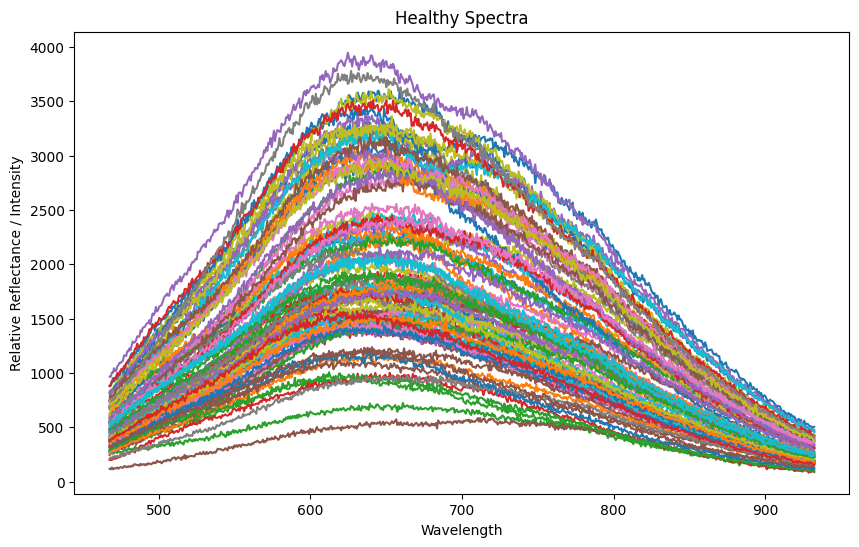

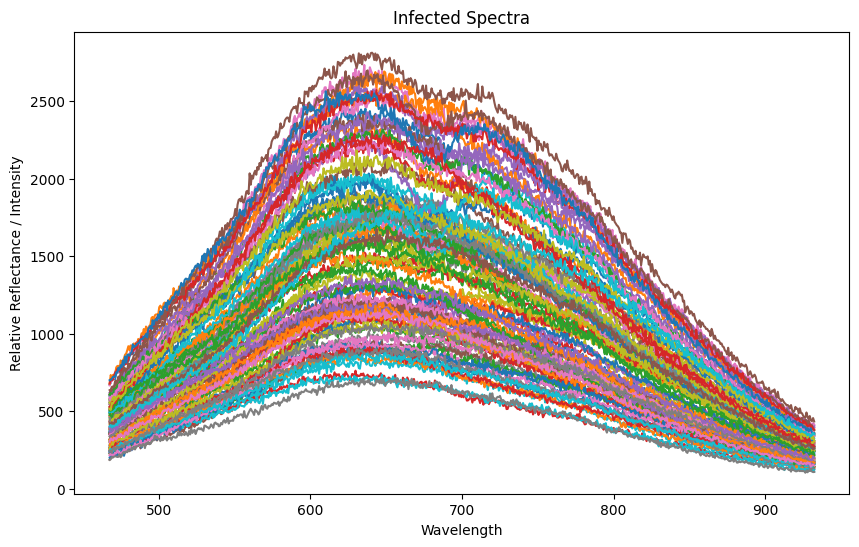

In [12]:
plot_spectra(healthy_sampled_all_seeds, 'Healthy Spectra')
plot_spectra(infected_sampled_all_seeds, 'Infected Spectra')

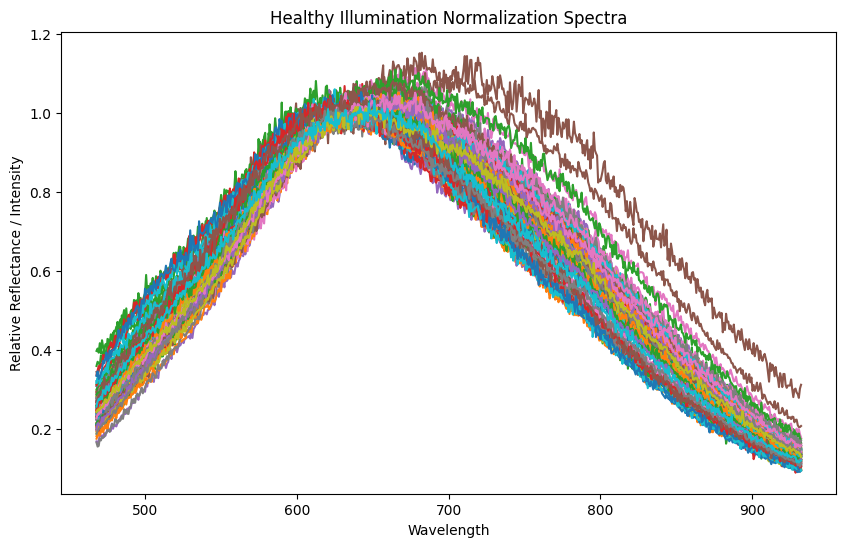

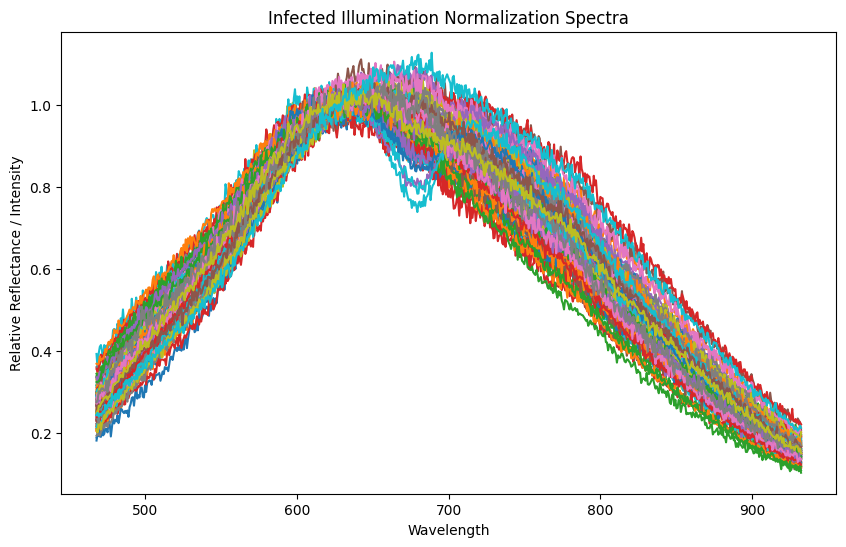

In [13]:
healthy_illumination_ratio_based_normalized = illumination_ratio_based_normalization(healthy_sampled_all_seeds, most_consistent_band)
infected_illumination_ratio_based_normalized = illumination_ratio_based_normalization(infected_sampled_all_seeds, most_consistent_band)

plot_spectra(healthy_illumination_ratio_based_normalized, 'Healthy Illumination Normalization Spectra')
plot_spectra(infected_illumination_ratio_based_normalized, 'Infected Illumination Normalization Spectra')

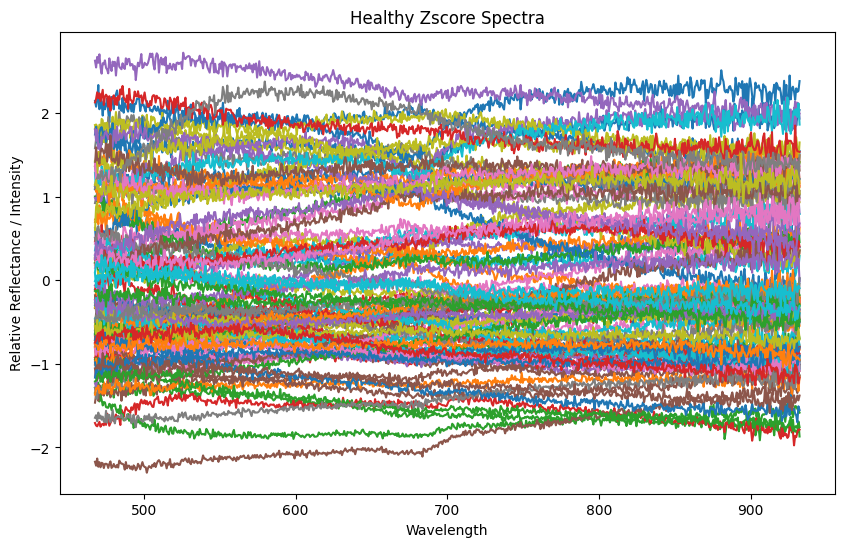

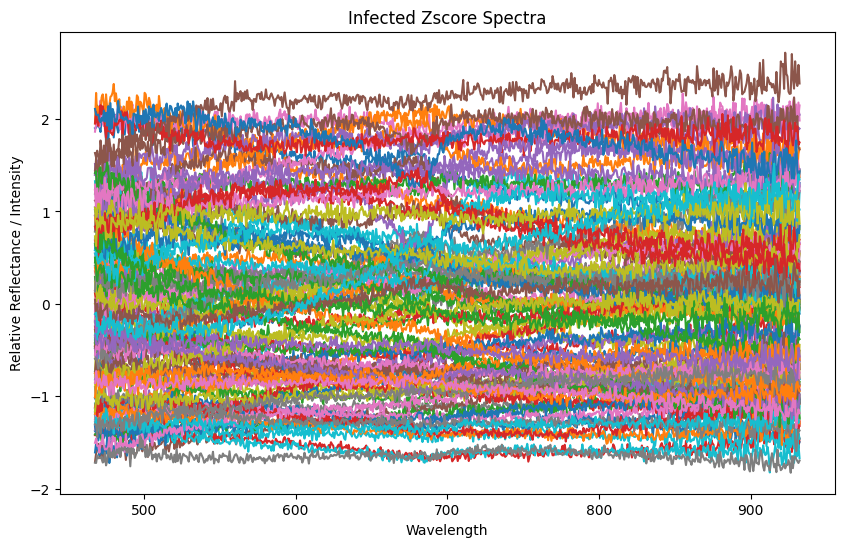

In [14]:
healthy_band_means = np.mean(healthy_sampled_all_seeds, axis=0, keepdims=True)
healthy_band_stds = np.std(healthy_sampled_all_seeds, axis=0, keepdims=True)
infected_band_means = np.mean(infected_sampled_all_seeds, axis=0, keepdims=True)
infected_band_stds = np.std(infected_sampled_all_seeds, axis=0, keepdims=True)

plot_spectra(zscore_normalize(healthy_sampled_all_seeds, healthy_band_means, healthy_band_stds), 'Healthy Zscore Spectra')
plot_spectra(zscore_normalize(infected_sampled_all_seeds, infected_band_means, infected_band_stds), 'Infected Zscore Spectra')

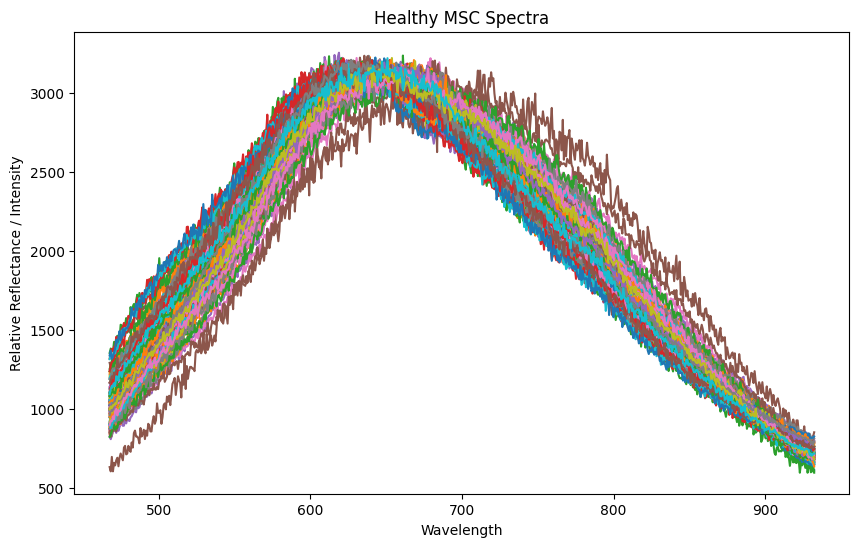

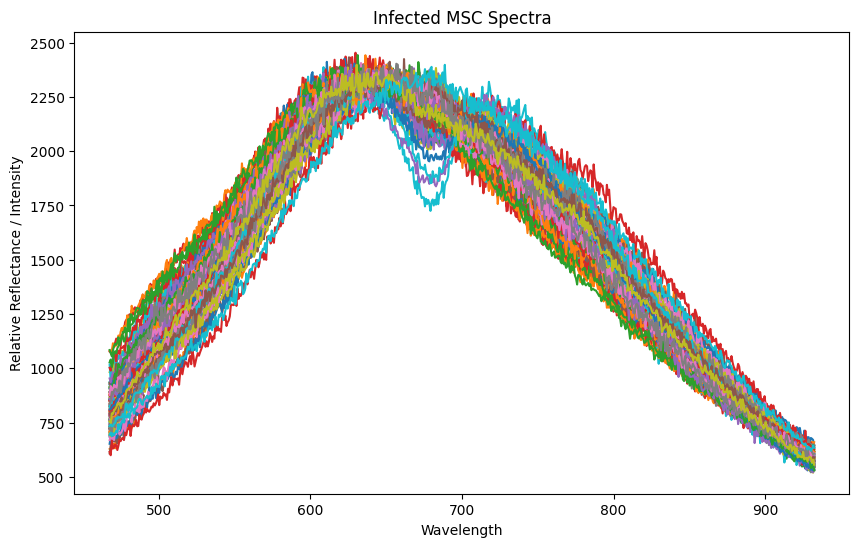

In [15]:
reference_band = most_consistent_band
ref_spectrum = healthy_sampled_all_seeds[:, reference_band]  # other bands could be used like ref_spectrum = np.mean(healthy_sampled_all_seeds, axis=1)
healthy_sampled_msc_spectra = apply_msc_and_shift_positive(healthy_sampled_all_seeds, ref_spectrum)
plot_spectra(healthy_sampled_msc_spectra, 'Healthy MSC Spectra')
ref_spectrum = infected_sampled_all_seeds[:, reference_band]
infected_sampled_msc_spectra = apply_msc_and_shift_positive(infected_sampled_all_seeds, ref_spectrum)
plot_spectra(infected_sampled_msc_spectra, 'Infected MSC Spectra')

In [16]:
healthy_illumination_normalized_band_means = np.mean(healthy_illumination_ratio_based_normalized, axis=0, keepdims=True)
healthy_illumination_normalized_band_stds = np.std(healthy_illumination_ratio_based_normalized, axis=0, keepdims=True)
infected_illumination_normalized_band_means = np.mean(infected_illumination_ratio_based_normalized, axis=0, keepdims=True)
infected_illumination_normalized_band_stds = np.std(infected_illumination_ratio_based_normalized, axis=0, keepdims=True)

healthy_illumination_zscore_normalized = zscore_normalize(healthy_illumination_ratio_based_normalized, healthy_illumination_normalized_band_means, healthy_illumination_normalized_band_stds)
infected_illumination_zscore_normalized = zscore_normalize(infected_illumination_ratio_based_normalized, infected_illumination_normalized_band_means, infected_illumination_normalized_band_stds)

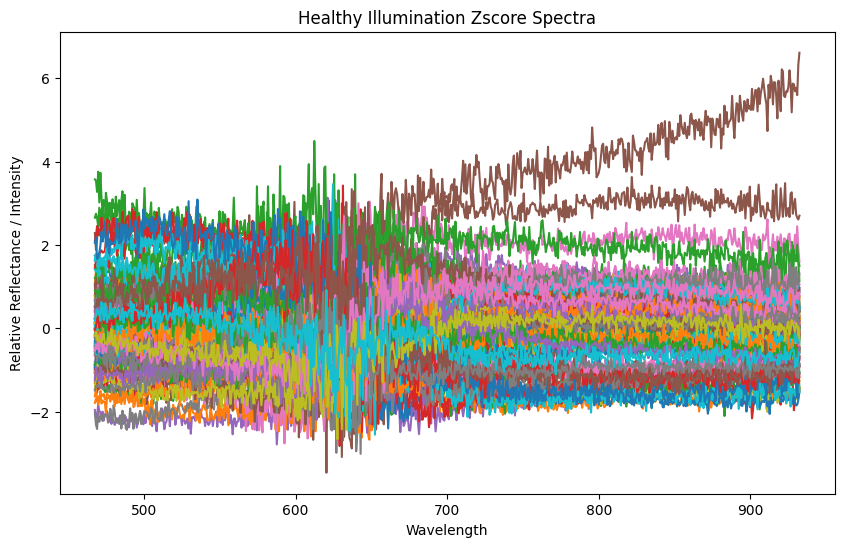

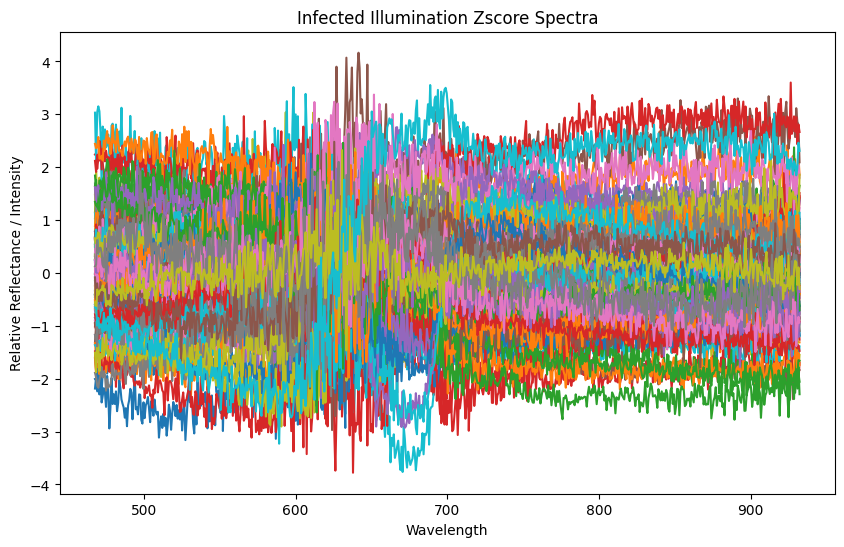

In [17]:
plot_spectra(healthy_illumination_zscore_normalized, 'Healthy Illumination Zscore Spectra')
plot_spectra(infected_illumination_zscore_normalized, 'Infected Illumination Zscore Spectra')

In [18]:
print('most consistant band:', most_consistent_band)
print('healthy mean:', healthy_illumination_zscore_normalized.shape)
print('infected mean:', infected_illumination_zscore_normalized.shape)
print('healthy standard deviation:', healthy_illumination_zscore_normalized.shape)
print('infected standard deviation:', infected_illumination_zscore_normalized.shape)

most consistant band: 223
healthy mean: (100, 640)
infected mean: (100, 640)
healthy standard deviation: (100, 640)
infected standard deviation: (100, 640)


The illumination ratio based normalization divided each band by one of the brightest bands essentially changing the pixel values to range between 0-1. A closer look at the means and standrad deviations of the bands shows that some bands differ more than 0.5 in their mean and 0.1 in their std which in real pixel values are about 50 and 100. That means that features can still be detected and are not completely smoothed by the normalization.

In [19]:
print(np.mean(healthy_illumination_normalized_band_means))
print(np.mean(infected_illumination_normalized_band_means))
print(np.allclose(healthy_illumination_normalized_band_means, infected_illumination_normalized_band_means, atol=0.1))
print(np.allclose(healthy_illumination_normalized_band_means, infected_illumination_normalized_band_means, atol=0.05))

0.6281003294926475
0.6420119227486741
True
True


In [20]:
print(np.std(healthy_illumination_normalized_band_stds))
print(np.std(infected_illumination_normalized_band_stds))
print(np.allclose(healthy_illumination_normalized_band_stds, infected_illumination_normalized_band_stds, atol=0.1))
print(np.allclose(healthy_illumination_normalized_band_stds, infected_illumination_normalized_band_stds, atol=0.01))

0.01716758742235713
0.014581715268669745
True
False


Plotting the different histograms of healthy and infected band means and standard deviations.

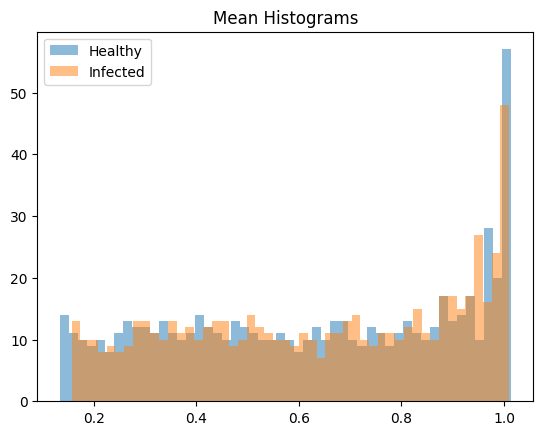

In [21]:
plt.hist(healthy_illumination_normalized_band_means.flatten(), bins=50, alpha=0.5, label='Healthy')
plt.hist(infected_illumination_normalized_band_means.flatten(), bins=50, alpha=0.5, label='Infected')
plt.title('Mean Histograms')
plt.legend()
plt.show()

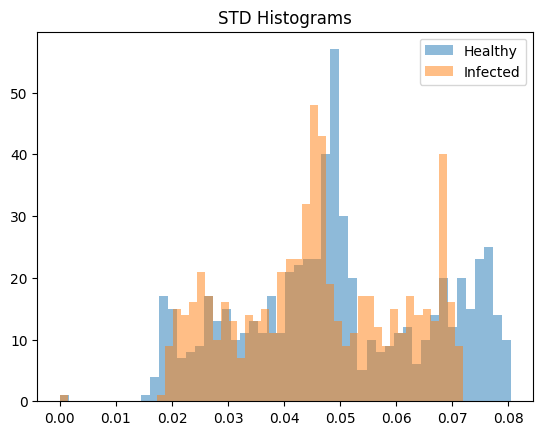

In [22]:
plt.hist(healthy_illumination_normalized_band_stds.flatten(), bins=50, alpha=0.5, label='Healthy')
plt.hist(infected_illumination_normalized_band_stds.flatten(), bins=50, alpha=0.5, label='Infected')
plt.title('STD Histograms')
plt.legend()
plt.show()

Use the normalization on a single seed.

In [23]:
def normalize_seed(seed, most_consistent_band, bands_means, bands_stds):
    seed_pixels, seed_pixels_spatial_indices, shape = extract_seed_pixels(seed)
    seed_illumination_ratio_based_normalization = illumination_ratio_based_normalization(seed_pixels, most_consistent_band)
    normalized_seed_pixels = zscore_normalize(seed_illumination_ratio_based_normalization, bands_means, bands_stds)
    normalized_seed = np.zeros(shape)
    normalized_seed[seed_pixels_spatial_indices[:, 0], seed_pixels_spatial_indices[:, 1], :] = normalized_seed_pixels
    return normalized_seed

In [24]:
seed = np.load(r'..\home\ARO.local\collaboration\Itai-tomer\tomer_data\Healthy\S3_LP3\Vnir\T1\T1L\seeds\1D.npy')
most_consistent_band = np.load(f'{normalization_parameters_path}\most_consistent_band.npy')
bands_means = np.load(f'{normalization_parameters_path}\healthy_illumination_ratio_based_normalized_means.npy')
bands_stds = np.load(f'{normalization_parameters_path}\healthy_illumination_ratio_based_normalized_stds.npy')
normalized_seed = normalize_seed(seed, most_consistent_band, bands_means, bands_stds)

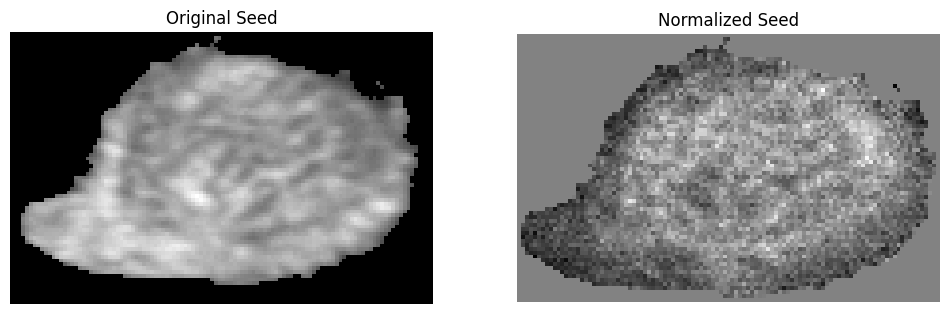

In [25]:
seed_band_400 = seed[:, :, 300]
normalized_seed_band_400 = normalized_seed[:,:,300]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(seed_band_400, cmap='gray')
ax[0].set_title('Original Seed')
ax[0].axis('off')

ax[1].imshow(normalized_seed_band_400, cmap='gray', vmin=np.min(normalized_seed_band_400), vmax=np.max(normalized_seed_band_400))
ax[1].set_title('Normalized Seed')
ax[1].axis('off')

plt.show()